# Working with a Synthetic Population in PostGIS

Synthetic populations are created to accurately represent demographic and geographic data for a population without revealing any underlying information about individuals. This is done through a process called [iterative proportional fitting](https://en.wikipedia.org/wiki/Iterative_proportional_fitting) that creates fake individuals and households that, when aggregated, match the characteristics of each census tract. I recently came across a full synthetic population available on the [Pitt Public Health Dynamics Lab website](https://fred.publichealth.pitt.edu/syn_pops), so I decided to download and experiment with it. 

Synthetic populations are traditionally used for things like epidemic modeling and emergency response planning, but I realized it could be useful for something else: calculating voter demographic and turnout data for state legislative districts. I haven't been able to do this until now because the Census Bureau doesn't seem to release data subdivided by state districts. But now that I have a synthetic population, all I need to do is write an SQL query to get the data I need. 

Below I show all the steps for getting started with Postgres, PostGIS and Python. At the end, I write a simple query that finds the voting age population for the Wisconsin State Assembly districts in 2016. 

# Setting up the Database

If you don't have Postgres or Postgis installed this can be done from the command line if you use [brew](https://brew.sh/) on a mac:
```
$ brew update
$ brew install postgresql
$ brew install postgis
$ brew services start postgresql
```

Then use these bash commands to create the database and add the postgis extension:
```
$ createdb -U psthomas synthpop
$ psql -U psthomas -d synthpop -c "CREATE EXTENSION postgis"
```
Also, set your user password (https://serverfault.com/questions/110154), and export it into the environment for use later:
```
$ export POSTGRESPASS='<your-postgres-pass>'
```

# Importing the Geography Data

The next step of importing geography data can be done on the commmand line with [ogr2ogr](https://gdal.org/drivers/vector/openfilegdb.html#examples), a command line utility for converting between geospatial data types. In this case, I'm converting an ESRI geodatabase (.gdb) into a Postgres database. This could be automated as a shell script, but I found it easiest to just use the command line. 

First, find the geodatabase that's relevant to your analysis on the [Census Bureau website](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-geodatabase-file.html).  Download it, then use `ogrinfo` to find the names of the different tables available:

```
$ ogrinfo "/Volumes/Misc/projects/snythpop/data/geographies/tlgdb_2019_a_us_legislative.gdb.zip"
INFO: Open of `/Volumes/Misc/projects/synthpop/data/geographies/tlgdb_2019_a_us_legislative.gdb.zip'
      using driver `OpenFileGDB' successful.
1: Congressional_Districts_116th (Multi Polygon)
2: State_Legislative_Districts_Upper (Multi Polygon)
3: State_Legislative_Districts_Lower (Multi Polygon)
4: Voting_Districts (Multi Polygon)
```
Next, use [ogr2ogr](https://gdal.org/drivers/vector/openfilegdb.html#examples) to load the desired geography table into the Postgres database you set up above. In this case I'm loading the shapes for the lower state legislative districts (`State_Legislative_Districts_Lower`). Note that I'm using the `POSTGRESPASS` environmental variable that we exported earlier for the password.  

```
$ ogr2ogr -overwrite -skipfailures -f "PostgreSQL" PG:"host=localhost user=psthomas dbname=synthpop password=$POSTGRESPASS" "/Volumes/Misc/projects/synthpop/data/geographies/tlgdb_2019_a_us_legislative.gdb.zip" "State_Legislative_Districts_Lower"
```
And here's a similar command loading the urban area outlines for the Milwaukee dot plot later:
```
$ ogr2ogr -overwrite -skipfailures -f "PostgreSQL" PG:"host=localhost user=psthomas dbname=synthpop password=$POSTGRESPASS" "/Volumes/Misc/projects/synthpop/data/geographies/tlgdb_2019_a_us_nationgeo.gdb.zip" "Urban_Area"
```
Note that I'm also loading the data directly from the zipped files because the files were unreadable if unzipped on my computer for some reason. Repeat these steps until you have all the geography tables you need for your analysis.

# Importing the Synthetic Population

The next step is to download and import the synthetic population data. I found the synthetic population data on the [Pitt Public Health Dynamics Lab website](https://fred.publichealth.pitt.edu/syn_pops), with the population originally developed by [RTI International](https://www.rti.org/impact/rti-us-synthetic-household-population%E2%84%A2) as a part of the [Models of Infectious Disease Agency Study](https://www.nigms.nih.gov/Research/specificareas/MIDAS/) (MIDAS). I manually downloaded the data for each state, extracted the files, and then used the code below to create tables and load the data. Note that the files are vey large (>30GB extracted), so you might want to put the data on an external drive.

From here on out, all the code is written in Python, with the SQL queries handled by psycopg2.

In [63]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import psycopg2
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib

In [3]:
# Note that if you have a failed transaction below, you need to rerun this to
# create a new connection without the broken transaction.
# https://stackoverflow.com/questions/10399727
pw = os.environ['POSTGRESPASS'] #Password from current environment
connection = psycopg2.connect(database="synthpop", user="psthomas", password=pw)
cursor = connection.cursor()

In [3]:
# Creating the households table
# Following this example: http://andrewgaidus.com/Build_Query_Spatial_Database/
# This DROP will cascade down to all indexes as well (https://stackoverflow.com/a/34011744)
cursor.execute('''
DROP TABLE IF EXISTS households;
''')

cursor.execute('''
CREATE TABLE households (
sp_id VARCHAR,
stcotrbg VARCHAR,
hh_race BIGINT,
hh_income BIGINT, 
latitude DOUBLE PRECISION,
longitude DOUBLE PRECISION,
coordinate geometry);
''')

connection.commit()

In [4]:
# Creating the people table
cursor.execute('''
DROP TABLE IF EXISTS people;
''')

cursor.execute('''
CREATE TABLE people (
sp_id VARCHAR,
sp_hh_id VARCHAR,
age BIGINT,
sex VARCHAR,
race BIGINT,
relate BIGINT,
school_id VARCHAR,
work_id VARCHAR);
''')

connection.commit()

In [5]:
# Populate the households table
 # This will load all population data
# filepath = os.path.join(os.getcwd(), 'data', 'synthpops')
# Just loading WI population for now.
filepath = os.path.join(os.getcwd(), 'data', 'synthpops', 'WI')

# Delete any existing data first
cursor.execute("DELETE FROM households")

# https://stackoverflow.com/questions/2186525/how-to-use-glob-to-find-files-recursively
# For some reason, this doesn't follow symlinks (https://bugs.python.org/issue33428), 
# and glob doesn't either. Just use direct drive filepath. 
path_list = list(Path(filepath).rglob('households.txt'))
bar = IntProgress(min=0, max=len(path_list), description='Households:') # Instantiate the bar
display(bar) # Display the bar

# http://www.postgresqltutorial.com/import-csv-file-into-posgresql-table/
for f in path_list:
    sql = '''
    COPY households(sp_id, stcotrbg, hh_race, hh_income, latitude, longitude) 
    FROM '{0}' DELIMITER '	' CSV HEADER;
    '''.format(f)
    cursor.execute(sql)
    bar.value += 1 # Increment the loading bar. 

# Commit the results
connection.commit()

IntProgress(value=0, description='Households:', max=72)

In [6]:
# Convert the lat/lon values to a geometry   
# https://www.kevfoo.com/2012/01/Importing-CSV-to-PostGIS/
# Note that 4326 is the srid of WGS 1984, the coordinate system used for the synpop,
# as noted in the documentation (2010_synth_pop_ver1_quickstart.pdf)
# 2010_synth_pop_ver1_quickstart.pdf  
# If you are loading these data into a GIS, then it is important to specify the 
# appropriate projection for the resulting GIS dataset. The coordinate system 
# for these latitude/longitude coordinates is the World Geodetic System of 1984.
cursor.execute('''
UPDATE households
SET coordinate = ST_GeomFromText('POINT(' || longitude || ' ' || latitude || ')', 4326);
''')

# Convert coordinate system to 4269 to match the Census geographies
# https://postgis.net/workshops/postgis-intro/index.html
# https://postgis.net/workshops/postgis-intro/projection.html
# https://postgis.net/workshops/postgis-intro/projection_exercises.html
# Note that the geography imports have an srid of 4269, so these coorinates
# need to be transformed to that for analysis.
# Note that UPDATE is correct syntax here, rather than ALTER, because
# you're changing table data, not changing table structure:
# https://stackoverflow.com/questions/11293042
cursor.execute('''
UPDATE households
SET coordinate = ST_Transform(coordinate, 4269);
''')
# SELECT ST_SRID(coordinate) FROM households LIMIT 1;
# 4269

# Commit the results
connection.commit()

In [7]:
# Populate the people table
# Delete any existing data first
cursor.execute("DELETE FROM people")

path_list = list(Path(filepath).rglob('people.txt'))
bar = IntProgress(min=0, max=len(path_list), description='People:') # Instantiate the bar
display(bar) # Display the bar

# http://www.postgresqltutorial.com/import-csv-file-into-posgresql-table/
for f in path_list:
    sql = '''
    COPY people(sp_id, sp_hh_id, age, sex, race, relate, school_id, work_id) 
    FROM '{}' DELIMITER '	' CSV HEADER;
    '''.format(f)
    cursor.execute(sql)
    bar.value += 1

# Commit the results
connection.commit()

IntProgress(value=0, description='People:', max=72)

In [8]:
# Add Indexes, this speeds up the joins
# Do this after loading, maybe faster this way?
# I think it is faster because index isn't updated with each copy operation.
# Note: All the Census geometries already have spatial indexes

# Create an index on coordinates.
# Still useful for coordinates because it uses RTree data structure
# https://gis.stackexchange.com/questions/265966
# https://postgis.net/workshops/postgis-intro/indexing.html
cursor.execute('''
CREATE INDEX house_geometry_index
ON households
USING GIST(coordinate);
''')

# Create an index on sp_id for faster joins
# https://www.postgresql.org/docs/11/indexes-intro.html
cursor.execute('''
CREATE INDEX house_id_index
ON households (sp_id);
''')

# Create an index on sp_hh_id for faster join onto households sp_id
# https://www.postgresql.org/docs/11/indexes-intro.html
cursor.execute('''
CREATE INDEX person_house_id_index
ON people (sp_hh_id);
''')

# https://postgis.net/workshops/postgis-intro/indexing.html#vacuuming
# VACUUM ANALYZE nyc_census_blocks;

# Commit the results
connection.commit()

# Milwaukee City Dot Plot

Now that we have the database set up, it's time to do some analysis. The synthetic population households are categorized by race, so let's start out by looking at a dot plot for the Milwaukee area. 

In [12]:
# https://www.census.gov/quickfacts/fact/table/milwaukeecountywisconsin/INC110217
# Milwaukee County GEOID = 55079
# dot_query = '''
# SELECT
#     c.geoid,
#     c.shape,
#     h.sp_id,
#     h.coordinate, 
#     h.hh_race
# FROM households AS h
#     JOIN county AS c
#     ON ST_Contains(c.shape, h.coordinate)
# WHERE c.geoid = '55079'
# LIMIT 20000;
# '''
# Milwaukee Urban Area is 57466 geoid
# https://www2.census.gov/geo/pdfs/maps-data/maps/reference/2010UAUC_List.pdf
dot_query = '''
SELECT
    u.geoid,
    h.sp_id,
    h.coordinate, 
    h.hh_race
FROM households AS h
    JOIN urban_area AS u
    ON ST_Contains(u.shape, h.coordinate)
WHERE u.geoid = '57466'
ORDER BY random()
LIMIT 10000;
'''
# https://stackoverflow.com/questions/8674718/best-way-to-select-random-rows-postgresql
# Try ORDER BY random() LIMIT 1000
mke_query = '''
SELECT u.geoid, u.shape
FROM urban_area AS u
WHERE u.geoid = '57466'
LIMIT 1;
'''
dot_df = gpd.GeoDataFrame.from_postgis(dot_query, connection, geom_col='coordinate')
mke_df = gpd.GeoDataFrame.from_postgis(mke_query, connection, geom_col='shape')
display(dot_df.head())

,geoid,sp_id,coordinate,hh_race
0,57466,54323919,POINT (-88.06619 43.05997),9
1,57466,55191668,POINT (-88.21111 42.98681),1
2,57466,53797371,POINT (-87.99648 43.02619),1
3,57466,53779988,POINT (-87.98308 43.07194),2
4,57466,55637265,POINT (-88.18592 43.20900),1


1 White alone  
2 Black or African American alone  
3 American Indian alone  
4 Alaska Native alone  
5 American Indian and Alaska Native tribes specified; or American Indian or Alaska native, not specified and no other races  
6 Asian alone  
7 Native Hawaiian or Other Pacific Islander alone  
8 Some other race alone  
9 Two or more major race groups  

So the green on the map is the lighter green, some other race alone (Hispanic)

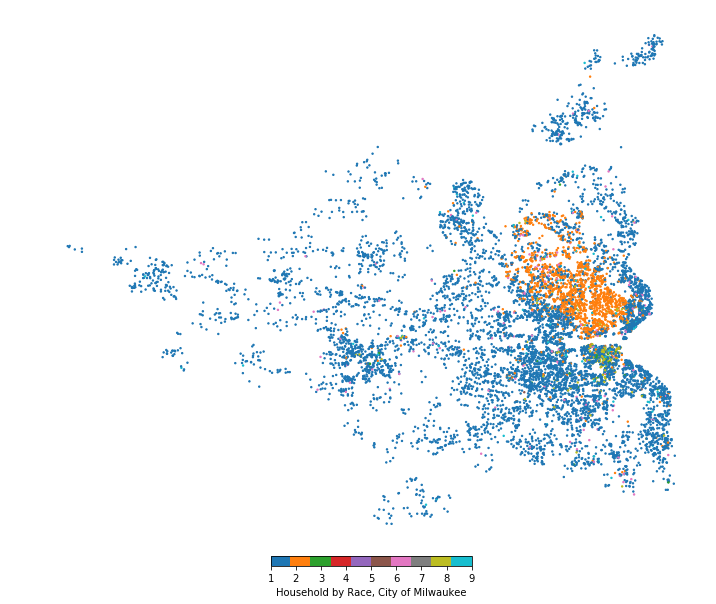

In [62]:
# http://geopandas.org/mapping.html
fig, ax = plt.subplots(figsize=(12,12)) 
#mke_df.plot(ax=ax)
#dot_df.hh_race.isin([1,2,6,8,9])
dot_df.plot(ax=ax, column='hh_race', legend=True, markersize=2, cmap='tab10',
    legend_kwds={'label': "Household by Race, City of Milwaukee", 'orientation': 'horizontal',
        'pad':0.01,'shrink':0.3})
ax.axis('off')
# 
# ax.set_xlim([-88.1, -87.95])
# ax.set_ylim([43.12, 43.20])
plt.show()

# 2016 Turnout, WI State Assembly

Next, I calculate the voting age population for each district in the Wisconsin State Assembly for 2016, and then use some election results data to calculate the district turnouts. As far as I can tell, the Census Bureau doesn't release their data broken down by state legislative districts, so having a synthetic population makes this previously-impossible analysis possible.

This computation takes about ten minutes on my computer (1.6 GHz, 4GB Ram Macbook Air), so I think I need to rent a cloud server to perform the computation for state legislatures across the entire nation.

In [9]:
# This query below is much slower because it does
# the spatial join on the entire population instead
# of just on the households. 
# query = '''
# WITH people_coords AS (
# SELECT p.sp_id, h.coordinate 
# FROM households AS h 
#     JOIN people AS p 
#     ON h.sp_id = p.sp_hh_id
# WHERE p.age >= 18
# ),
# wisclower_geo AS (
# SELECT geoid, shape
# FROM state_legislative_districts_lower
# WHERE geoid LIKE '55%'
# )
# SELECT
#     w.geoid AS geoid,
#     count(p.sp_id) AS voting_age_pop
# FROM people_coords AS p
#     JOIN wisclower_geo AS w
#     ON ST_Contains(w.shape, p.coordinate)
# GROUP BY w.geoid
# ORDER BY voting_age_pop DESC;
# '''

# Note, WI FIPS code is 55, and the geoid is a combination 
# of FIPS + lower chamber code, 5 chars long.
# Joining and summarizing: https://postgis.net/workshops/postgis-intro/joins.html

# It's much faster to select out the households first,
# then join that on the population. This is because you're 
# duplicating the ST_Contains by the pop of each house and 
# there are 2.2 million households vs. 5.5 million people.
query = '''
WITH lower_households AS (
SELECT
    s.geoid,
    h.sp_id,
    h.coordinate
FROM households AS h
    JOIN state_legislative_districts_lower AS s
    ON ST_Contains(s.shape, h.coordinate)
WHERE s.geoid LIKE '55%'
),
wisclower_vap AS (
SELECT
    geoid,
    count(p.sp_id) AS voting_age_pop 
FROM people AS p 
    JOIN lower_households AS l 
    ON l.sp_id = p.sp_hh_id
WHERE p.age >= 18
GROUP BY l.geoid
ORDER BY voting_age_pop DESC)

SELECT 
    w.geoid, 
    w.voting_age_pop,
    s.shape 
FROM wisclower_vap AS w
    JOIN state_legislative_districts_lower as s
    ON w.geoid = s.geoid
LIMIT 1000;
'''
# ON ST_Within(p.coordinate, w.shape)

# https://stackoverflow.com/questions/36732075
poly_df = gpd.GeoDataFrame.from_postgis(query, connection, geom_col='shape')
poly_df.head()

,geoid,voting_age_pop,shape
0,55001,44343,"MULTIPOLYGON (((-87.94429 44.67813, -87.93753 ..."
1,55002,41595,"MULTIPOLYGON (((-88.12635 44.46920, -88.12572 ..."
2,55003,42106,"MULTIPOLYGON (((-88.16546 44.13169, -88.16546 ..."
3,55004,42937,"MULTIPOLYGON (((-88.14988 44.50133, -88.14845 ..."
4,55005,41751,"MULTIPOLYGON (((-88.19132 44.33248, -88.19131 ..."


In [64]:
# Optional write to GeoJSON:
# poly_outpath = os.path.join(os.getcwd(), 'data', 'output', 'wiassembly_vap.geojson')
# poly_df.to_file(poly_outpath, driver='GeoJSON')
# Optional, read from GeoJSON if possible:
# poly_path = os.path.join(os.getcwd(), 'data', 'output', 'wiassembly_vap.geojson')
# poly_df = gpd.read_file(poly_path, driver='GeoJSON', geom_col='shape')
# poly_df = poly_df.rename(columns={'geometry': 'shape'}).set_geometry('shape')

In [65]:
# Elections Data from a previous analysis: https://pstblog.com/2019/03/05/voting-power-comprehensive
results_path = os.path.join(os.getcwd(), 'data', 'election_results', 'state_house.csv')
results_df = pd.read_csv(results_path)

In [66]:
final_df = poly_df.merge(results_df[['geoid','totalvote', 'dem_margin']], on='geoid')
final_df['turnout'] = (final_df['totalvote']/final_df['voting_age_pop'])*100
final_df['rep_margin'] = -1*final_df.dem_margin
final_df[['geoid', 'shape', 'voting_age_pop', 'totalvote', 'rep_margin', 'turnout']] \
    .sort_values(by='turnout', ascending=False).head(5)

,geoid,shape,voting_age_pop,totalvote,rep_margin,turnout
73,55076,"MULTIPOLYGON (((-89.42083 43.06248, -89.42054 ...",45667,40505.0,-66.043698,88.696433
11,55014,"MULTIPOLYGON (((-88.18598 43.08239, -88.18597 ...",43184,34935.0,14.504079,80.898018
76,55079,"MULTIPOLYGON (((-89.26300 43.10712, -89.26200 ...",46805,36316.0,-27.827955,77.590001
53,55056,"MULTIPOLYGON (((-88.88675 44.24121, -88.88674 ...",42228,32573.0,29.076229,77.136023
35,55038,"MULTIPOLYGON (((-88.80975 43.02505, -88.80962 ...",42995,32996.0,25.518245,76.743807


In [38]:
# Assembly turnout was 57.9%, how does this compare with my values?
# https://en.wikipedia.org/wiki/2016_Wisconsin_State_Assembly_election#District
totalvote = final_df.totalvote.sum()
vap = final_df.voting_age_pop.sum()
turnout = totalvote/vap
print('My Voting Age Population: ', vap)
print('My Vote Total: ', totalvote)
print('My Overall turnout: ', turnout)
# My overall turnout:  0.6180808677622799
# From: https://elections.wi.gov/sites/default/files/page/voter_turnout_partisan_nonpartisan_through_april_2_49467.xlsx
# Year 2016
# Voting Age Population 4,461,068
# General Elections Votes 3,004,051
# General Election Turnout 67.34%
# Although the above numbers are for the general election for all voters.
# Fewer people voted for State Assembly, so these numbers are more accurate, showing 2,587,171 total votes:
# https://en.wikipedia.org/wiki/2016_Wisconsin_State_Assembly_election#District
# Actual assembly turnout: 2,587,171/4,461,068 = 0.57899
# So, overall this does overestimate turnout for the assembly because it has a lower VAP value,
# due to the data being from the 2007-2011 census.

My Voting Age Population:  4155055
My Vote Total:  2568160.0
My Overall turnout:  0.6180808677622799


In [55]:
# scatter_df = final_df[['rep_margin', 'turnout', 'totalvote']].copy()
# scatter_df.plot(kind='scatter', x='rep_margin', y='turnout', s='totalvote')

In [56]:
plot_df = final_df.copy()
plot_df['rep_margin'] = plot_df['rep_margin'].clip(lower=-25.0, upper=25.0)
#plot_df['turnout'] = plot_df.turnout*100
#https://spatialreference.org/ref/epsg/2288/
plot_df = plot_df.to_crs({'init': 'EPSG:2288'}) #5070 2289

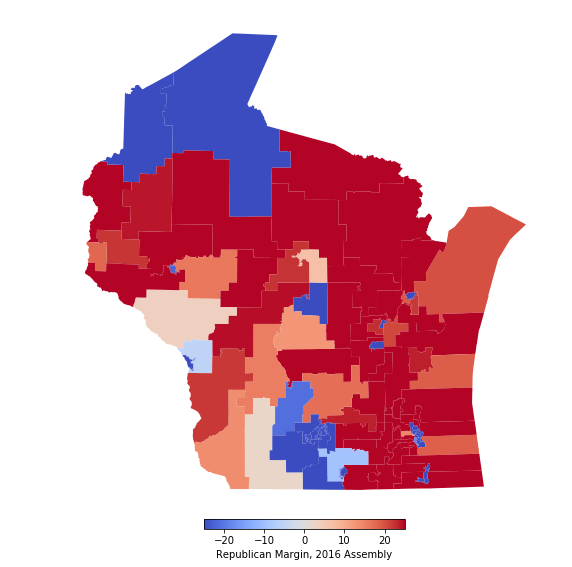

In [57]:
fig, ax = plt.subplots(figsize=(12,11))  #figsize=(20,10)
ax.axis('off')
plot_df.plot(ax=ax, column='rep_margin', linewidth=0.1, cmap='coolwarm',legend=True,
    legend_kwds={'label': "Republican Margin, 2016 Assembly", 'orientation': 'horizontal','pad':0.01, 'shrink':0.3}) 
# linewidth=1 k=3, cmap='coolwarm' seismic bwr
plt.show()

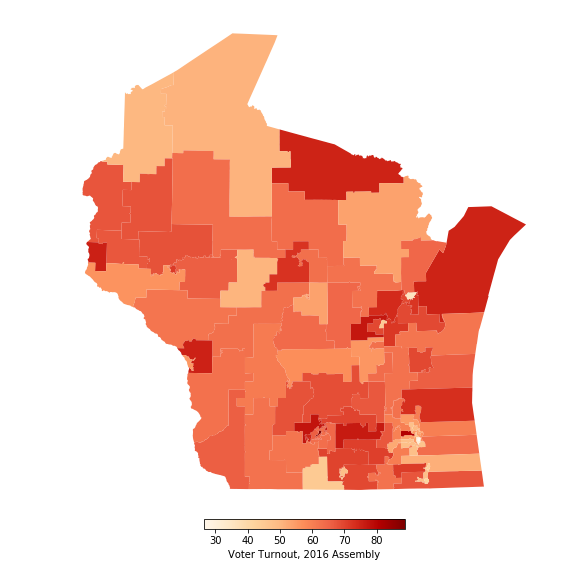

In [58]:
fig, ax = plt.subplots(figsize=(12,11))  #figsize=(20,10)
ax.axis('off')
plot_df.plot(ax=ax, column='turnout', k=3, linewidth=0.1, cmap='OrRd', legend=True,
    legend_kwds={'label': "Voter Turnout, 2016 Assembly", 'orientation': 'horizontal',
    'pad':0.01, 'shrink':0.3}) 
# 'anchor': (0.0,0.0) cmap='OrRd' Reds 'anchor': (0.0,0.2)
# 
# ax.set_xlim([-120, -68])
# ax.set_ylim([25, 50])
plt.show()

# Conclusion

The purpose of this post was to provide a small tutorial on loading and querying synthetic population data in Postgres. I've only scratched the surface of what is possible with this data, so stay tuned for future posts on this topic. I think it would be interesting to calculate turnout for every state legislative seat in my dataset, but I would have to move beyond my machine into the cloud to do so. Perhaps I could use something like [BigQuery](https://cloud.google.com/bigquery) instead.   

I really wish the Census Bureau would move towards releasing data in this format. One of the problems with reporting on elections is margins often get more attention than the turnout. This might be because turnout is very difficult/impossible to calculate for many seats, so having annual synthetic population data available could go a long way towards fixing this problem. This would be especially helpful because, although it's still useful for other purposes, the synthetic population I used in this post will soon be obsolete for political analysis due to changes in population.